The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1


# Redes Adversariais Generativas
:label:`sec_basic_gan`


Ao longo da maior parte deste livro, falamos sobre como fazer previsões. De uma forma ou de outra, usamos redes neurais profundas, mapeamentos aprendidos de exemplos de dados para rótulos. Esse tipo de aprendizado é chamado de aprendizado discriminativo, pois gostaríamos de ser capazes de discriminar entre fotos de gatos e fotos de cachorros. Classificadores e regressores são exemplos de aprendizagem discriminativa. E as redes neurais treinadas por retropropagação mudaram tudo que pensávamos saber sobre aprendizagem discriminativa em grandes *datasets* complicados. A precisão da classificação em imagens de alta resolução passou de inútil para o nível humano (com algumas ressalvas) em apenas 5-6 anos. Vamos poupar você de outro discurso sobre todas as outras tarefas discriminativas em que as redes neurais profundas se saem surpreendentemente bem.

Mas o aprendizado de máquina é mais do que apenas resolver tarefas discriminativas. Por exemplo, dado um grande conjunto de dados, sem rótulos, podemos querer aprender um modelo que capture de forma concisa as características desses dados. Dado esse modelo, poderíamos amostrar exemplos de dados sintéticos que se assemelham à distribuição dos dados de treinamento. Por exemplo, dado um grande corpus de fotografias de rostos, podemos querer ser capazes de gerar uma nova imagem fotorrealística que pareça plausivelmente proveniente do mesmo *dataset*. Esse tipo de aprendizado é chamado de modelagem generativa.

Até recentemente, não tínhamos nenhum método que pudesse sintetizar novas imagens fotorrealistas. Mas o sucesso das redes neurais profundas para aprendizagem discriminativa abriu novas possibilidades. Uma grande tendência nos últimos três anos tem sido a aplicação de redes profundas discriminativas para superar desafios em problemas que geralmente não consideramos problemas de aprendizagem supervisionada. Os modelos de linguagem de rede neural recorrente são um exemplo do uso de uma rede discriminativa (treinada para prever o próximo caractere) que, uma vez treinada, pode atuar como um modelo gerador.

Em 2014, um artigo inovador apresentou Redes adversariais gerativas (GANs) :cite:`Goodfellow.Pouget-Abadie.Mirza.ea.2014`, uma nova maneira inteligente de alavancar o poder dos modelos discriminativos para obter bons modelos generativos. Em sua essência, as GANs confiam na ideia de que um gerador de dados é bom se não podemos distinguir os dados falsos dos reais. Em estatística, isso é chamado de teste de duas amostras - um teste para responder à pergunta se os conjuntos de dados $X=\{x_1,\ldots, x_n\}$ and $X'=\{x'_1,\ldots, x'_n\}$ foram retirados da mesma distribuição. A principal diferença entre a maioria dos artigos de estatística e os GANs é que os últimos usam essa ideia de forma construtiva. Em outras palavras, em vez de apenas treinar um modelo para dizer "ei, esses dois conjuntos de dados não parecem vir da mesma distribuição", eles usam o [teste de duas amostras](https://en.wikipedia.org/wiki/Two-sample_hypothesis_testing) para fornecer sinais de treinamento para um modelo generativo. Isso nos permite melhorar o gerador de dados até que ele gere algo que se pareça com os dados reais. No mínimo, ele precisa enganar o classificador. Mesmo que nosso classificador seja uma rede neural profunda de última geração.

![Redes Adversariais Generativas](http://d2l.ai/_images/gan.svg)
:label:`fig_gan`


A arquitetura GAN é ilustrada em :numref:`fig_gan`.
Como você pode ver, há duas peças na arquitetura GAN - primeiro, precisamos de um dispositivo (digamos, uma rede profunda, mas realmente pode ser qualquer coisa, como um mecanismo de renderização de jogo) que pode potencialmente ser capaz de gerar dados que parecem assim como a coisa real. Se estamos lidando com imagens, isso precisa gerar imagens. Se estamos lidando com a fala, ela precisa gerar sequências de áudio e assim por diante. Chamamos isso de rede do gerador. O segundo componente é a rede discriminadora. Ele tenta distinguir dados falsos e reais uns dos outros. Ambas as redes competem entre si. A rede do gerador tenta enganar a rede do discriminador. Nesse ponto, a rede discriminadora se adapta aos novos dados falsos. Essas informações, por sua vez, são utilizadas para melhorar a rede do gerador, e assim por diante.

O discriminador é um classificador binário para distinguir se a entrada $x$ é real (dos dados reais) ou falsa (do gerador). Normalmente, o discriminador gera uma previsão escalar $o\in\mathbb R$ para a entrada $\mathbf x$, como usar uma camada densa com tamanho oculto 1 e, em seguida, aplicar a função sigmóide para obter a probabilidade prevista $D(\mathbf x) = 1/(1+e^{-o})$. Suponha que o rótulo $y$ para os dados verdadeiros seja $1$ e $0$ para os dados falsos. Treinamos o discriminador para minimizar a perda de entropia cruzada, *ou seja*,

$$ \min_D \{ - y \log D(\mathbf x) - (1-y)\log(1-D(\mathbf x)) \},$$

Para o gerador, ele primeiro desenha algum parâmetro $\mathbf z\in\mathbb R^d$ de uma fonte de aleatoriedade, *por exemplo*, uma distribuição normal $\mathbf z \sim \mathcal{N} (0, 1)$. Frequentemente chamamos $\mathbf z$ como a variável latente.
Em seguida, aplica uma função para gerar $\mathbf x'=G(\mathbf z)$.  O objetivo do gerador é enganar o discriminador para classificar $\mathbf x'=G(\mathbf z)$ como dados verdadeiros, *ou seja*, queremos $D( G(\mathbf z)) \approx 1$.
Em outras palavras, para um determinado discriminador $D$, atualizamos os parâmetros do gerador $G$ para maximizar a perda de entropia cruzada quando $y=0$, *ou seja*,

$$ \max_G \{ - (1-y) \log(1-D(G(\mathbf z))) \} = \max_G \{ - \log(1-D(G(\mathbf z))) \}.$$

Se o gerador fizer um trabalho perfeito, então $D(\mathbf x')\approx 1$ então a perda acima próxima a 0, o que resulta em gradientes muito pequenos para fazer um bom progresso para o discriminador. Então, comumente, minimizamos a seguinte perda:

$$ \min_G \{ - y \log(D(G(\mathbf z))) \} = \min_G \{ - \log(D(G(\mathbf z))) \}, $$

que é apenas alimentar $\mathbf x'=G(\mathbf z)$ no discriminador, mas dando o rótulo $y=1$.


Resumindo, $D$ e $G$ estão jogando um jogo "minimax" com a função objetivo abrangente:

$$min_D max_G \{ -E_{x \sim \text{Data}} log D(\mathbf x) - E_{z \sim \text{Noise}} log(1 - D(G(\mathbf z))) \}.$$



Muitos dos aplicativos GANs estão no contexto de imagens. Como demonstração, vamos nos contentar em ajustar primeiro uma distribuição muito mais simples. Ilustraremos o que acontece se usarmos GANs para construir o estimador de parâmetros mais ineficiente do mundo para um gaussiano. Vamos começar.


In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

## Gerando Alguns Dados "Reais"

Como esse será o exemplo mais bobo do mundo, simplesmente geramos dados extraídos de uma gaussiana.


In [2]:
X = torch.normal(0.0, 1, (1000, 2))
A = torch.tensor([[1, 2], [-0.1, 0.5]])
b = torch.tensor([1, 2])
data = torch.matmul(X, A) + b

Vamos ver o que temos. Esta deve ser uma Gaussiana deslocada de alguma forma bastante arbitrária com média $b$ e matriz de covariância $A^TA$.


The covariance matrix is
tensor([[1.0100, 1.9500],
        [1.9500, 4.2500]])


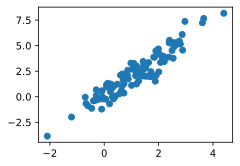

In [3]:
d2l.set_figsize()
d2l.plt.scatter(data[:100, (0)].detach().numpy(), data[:100, (1)].detach().numpy());
print(f'The covariance matrix is\n{torch.matmul(A.T, A)}')

In [4]:
batch_size = 8
data_iter = d2l.load_array((data,), batch_size)

## Gerador

Nossa rede de geradores será a rede mais simples possível - um modelo linear de camada única. Isso porque estaremos conduzindo essa rede linear com um gerador de dados Gaussiano. Portanto, ele literalmente só precisa aprender os parâmetros para falsificar as coisas perfeitamente.


In [5]:
net_G = nn.Sequential(nn.Linear(2, 2))

## Discriminador

Para o discriminador, seremos um pouco mais discriminativos: usaremos um MLP com 3 camadas para tornar as coisas um pouco mais interessantes.


In [6]:
net_D = nn.Sequential(
    nn.Linear(2, 5), nn.Tanh(),
    nn.Linear(5, 3), nn.Tanh(),
    nn.Linear(3, 1))

## Treinamento

Primeiro, definimos uma função para atualizar o discriminador.


In [7]:
#@save
def update_D(X, Z, net_D, net_G, loss, trainer_D):
    """Update discriminator."""
    batch_size = X.shape[0]
    ones = torch.ones((batch_size,), device=X.device)
    zeros = torch.zeros((batch_size,), device=X.device)
    trainer_D.zero_grad()
    real_Y = net_D(X)
    fake_X = net_G(Z)
    # Do not need to compute gradient for `net_G`, detach it from
    # computing gradients.
    fake_Y = net_D(fake_X.detach())
    loss_D = (loss(real_Y, ones.reshape(real_Y.shape)) +
              loss(fake_Y, zeros.reshape(fake_Y.shape))) / 2
    loss_D.backward()
    trainer_D.step()
    return loss_D

O gerador é atualizado de forma semelhante. Aqui, reutilizamos a perda de entropia cruzada, mas mudamos o rótulo dos dados falsos de $0$ para $1$.


In [8]:
#@save
def update_G(Z, net_D, net_G, loss, trainer_G):
    """Update generator."""
    batch_size = Z.shape[0]
    ones = torch.ones((batch_size,), device=Z.device)
    trainer_G.zero_grad()
    # We could reuse `fake_X` from `update_D` to save computation
    fake_X = net_G(Z)
    # Recomputing `fake_Y` is needed since `net_D` is changed
    fake_Y = net_D(fake_X)
    loss_G = loss(fake_Y, ones.reshape(fake_Y.shape))
    loss_G.backward()
    trainer_G.step()
    return loss_G

Tanto o discriminador quanto o gerador realizam uma regressão logística binária com a perda de entropia cruzada. Usamos Adam para facilitar o processo de treinamento. Em cada iteração, primeiro atualizamos o discriminador e depois o gerador. Visualizamos perdas e exemplos gerados.


In [9]:
def train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data):
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)
    trainer_D = torch.optim.Adam(net_D.parameters(), lr=lr_D)
    trainer_G = torch.optim.Adam(net_G.parameters(), lr=lr_G)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(num_epochs):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for (X,) in data_iter:
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim))
            metric.add(update_D(X, Z, net_D, net_G, loss, trainer_D),
                       update_G(Z, net_D, net_G, loss, trainer_G),
                       batch_size)
        # Visualize generated examples
        Z = torch.normal(0, 1, size=(100, latent_dim))
        fake_X = net_G(Z).detach().numpy()
        animator.axes[1].cla()
        animator.axes[1].scatter(data[:, 0], data[:, 1])
        animator.axes[1].scatter(fake_X[:, 0], fake_X[:, 1])
        animator.axes[1].legend(['real', 'generated'])
        # Show the losses
        loss_D, loss_G = metric[0]/metric[2], metric[1]/metric[2]
        animator.add(epoch + 1, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec')

Agora especificamos os hiperparâmetros para se ajustar à distribuição gaussiana.


loss_D 0.693, loss_G 0.693, 1539.5 examples/sec


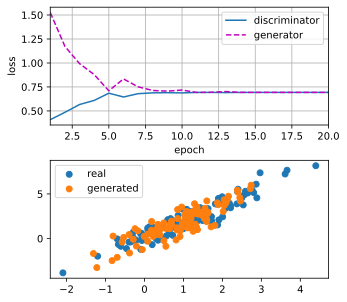

In [10]:
lr_D, lr_G, latent_dim, num_epochs = 0.05, 0.005, 2, 20
train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G,
      latent_dim, data[:100].detach().numpy())

## Resumo

* Redes adversárias gerativas (GANs) são compostas por duas redes profundas, a geradora e a discriminadora.
* O gerador gera a imagem o mais próximo possível da imagem verdadeira para enganar o discriminador, maximizando a perda de entropia cruzada, *ou seja* $\max \log(D(\mathbf{x'}))$.
O discriminador tenta distinguir as imagens geradas das imagens verdadeiras, minimizando a perda de entropia cruzada, *ou seja*, $\min - y \log D(\mathbf{x}) - (1-y)\log(1-D(\mathbf{x}))$.

## Exercícios

* Existe um equilíbrio onde o gerador vence, *ou seja* o discriminador acaba incapaz de distinguir as duas distribuições em amostras finitas?


[Discussões](https://discuss.d2l.ai/t/1082)


<!--stackedit_data:
eyJoaXN0b3J5IjpbLTEyMDg0NzMzMjEsLTE3NDg3NDg5OCwyMz
M1MTE3NSwtMTUxNDY5NjkzLDIxMDU0NzU2NzBdfQ==
-->
